In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

input_dir = r'''trainset_python\python'''
file_list = glob.glob(input_dir + r'''\**\*.npy''' , recursive=True)
label_list =[]
data_list = []
data = np.array([])
for file in file_list :
    if '.labels' in file :
        label_list.append(file)
    elif '.npy' in file: 
        data_list.append(file)

# load features list
for file in data_list:
    if data.shape[0] == 0:
        data = np.load(file)
    else:
        file_data = np.load(file)
        data = np.vstack([data,file_data])
        

#data_label = np.load(r'''trainset_python\python\comcuc\25627.labels.npy''')
print (data.shape)
#print(data_label.shape)
print(len(label_list))
print(len(data_list))

(120000, 548)
1200
1200


1. The data consist of 1200 file each file is 100 time steps and 458 feature (100 vectors of 548 features for 20 seconds of audio).
    - ZCR mean, ZCR std 
    - 14 YIN pitch estimates
    - 60 Mel frequency bin means & stds, raw and clean
    - 20 {MFCCs + ∆ + ∆∆} means & stds, raw and clean
    - spectral flatness, centroid, flux, energy, power, bandwidth means and & stds, raw and clean
    - 7 spectral contrasts means & stds, raw and clean
2. and there is a corresponding label file that have a label for each time steps

In [5]:
from scipy import stats as st
#load label list
label_data = np.array([])
for file in label_list:
        file_data = np.load(file).T
        mode_label,_ = st.mode(file_data)
        label_data = np.append(label_data,mode_label)
print(label_data.shape)

C:\Users\moham\AppData\Local\Temp\ipykernel_19388\1105618780.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_label,_ = st.mode(file_data)


(120000,)


[0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 1.]


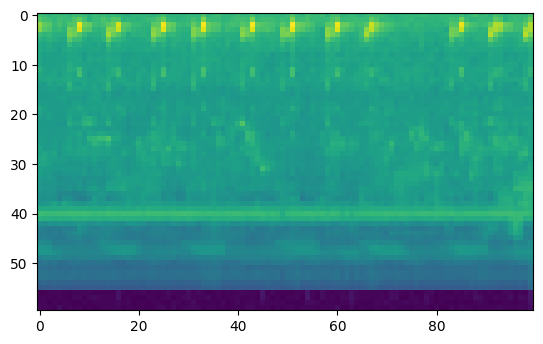

In [12]:
norm = np.linalg.norm(data[0:200,20:80])
normalized_array =data[0:100,20:80]
plt.imshow(normalized_array.T)
print(label_data[0:100])

calculate the occurrence of each label.

In [13]:
# count occurrences of each label
label_for_wights = label_data.reshape((-1,100))
max_label  = np.array(label_for_wights)
max_label = np.max(label_for_wights,axis = 1)
#print(max_label.shape)
occ = np.array([np.count_nonzero(label_data == i) for i in range(7)])
occ_sum = np.sum(occ)
wight = occ_sum/occ
print(occ)
print(wight)
occ = np.array([np.count_nonzero(max_label == i) for i in range(7)])
occ_sum = np.sum(occ)
wight = occ_sum/occ
print(occ)
print(wight)

[85358  5833  8954  8198  2324  5111  4222]
[ 1.40584362 20.57260415 13.40183158 14.63771652 51.63511188 23.47877128
 28.42254856]
[ 30 196 190 195 195 197 197]
[40.          6.12244898  6.31578947  6.15384615  6.15384615  6.09137056
  6.09137056]


removing the redundant labels

In [14]:
import re
with open(input_dir+r'\feature_names.txt') as my_file:
    feature_text = my_file.read() 
    feature_text = feature_text.splitlines()
    #print(feature_text)
    #extract raw std
    regex = re.compile(r'raw_(.*)_std_(.*)')
    raw_std = [regex.search(feature).group() for feature in feature_text if regex.search(feature)!= None ]
    #print (raw_std)
    print(len(raw_std))

127


In [15]:
data_mel = data[:,:]
#data_label = data_label[:,1]
print(data_mel.shape)
df = pd.DataFrame(data_mel, columns = feature_text)
df['label'] = label_data
df = df.drop(columns=['zcr_mean'
                 ,'raw_bandwidth_mean'
                 ,'raw_energy_mean'
                 ,'raw_power_mean'
                 ,'cln_power_mean'
                 ,'cln_energy_mean'])
df = df.drop(columns=raw_std)
print(df.shape)
#print(list(enumerate(df.columns.to_numpy())))

(120000, 548)
(120000, 416)


In [16]:
final_data = df.to_numpy()
final_data = final_data.astype('float32')
final_data_reshaped = np.reshape(final_data,(1200,-1,416))
#label_data_reshaped = np.reshape(label_data,(1200,-1)) 
final_data_reshaped = np.reshape(final_data,(1200,1,100,416))
print(final_data_reshaped.shape)
#print(label_data_reshaped.shape)

(1200, 1, 100, 416)


In [18]:
import torch
def count_parameters(model: torch.nn.Module, only_trainable: bool = True) -> int:
    """
    Count (trainable) paramaters of specified model.
    
    :param model: model for which to compute the amount of (trainable) parameters
    :param only_trainable: only include trainable parameters in total count
    :return: amount of (trainable) parameters of the specified model
    """
    return sum(parameter.numel() for parameter in model.parameters() if any(
        (not only_trainable, only_trainable and parameter.requires_grad)))

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print(torch.cuda.is_available())
device = torch.device("cuda" )

True


In [22]:

#split to train / validate

# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
print(final_data_reshaped.shape)
numTrainSamples = int(len(final_data_reshaped) * TRAIN_SPLIT)
numValSamples = int(len(final_data_reshaped) * VAL_SPLIT)
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
(trainData, valData) = torch.utils.data.random_split(final_data_reshaped,[numTrainSamples, numValSamples],generator=torch.Generator().manual_seed(42))

INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 10



trainDataLoader = torch.utils.data.DataLoader(trainData, shuffle=True,batch_size=BATCH_SIZE)
valDataLoader = torch.utils.data.DataLoader(valData, batch_size=BATCH_SIZE)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE


(1200, 1, 100, 416)


In [34]:
def eval_fun(preds,target_i):
    tp = torch.sum(torch.eq(preds,1) & torch.eq(target_i,1),dim = 0)
    tn = torch.sum(torch.eq(preds,0) & torch.eq(target_i,0),dim = 0)
    fp = torch.sum(torch.eq(preds,1) & torch.eq(target_i,0),dim = 0)
    fn = torch.sum(torch.eq(preds,0) & torch.eq(target_i,1),dim = 0)
    acc = (tp + tn) / (tp + tn + fp + fn +1e-6)
    recall = tp / (tp + fn+1e-6)
    prec = tp / (tp + fp+1e-6)
    f1 = 2*(recall*prec)/(recall+prec+1e-6)
    return acc,recall,prec,f1

In [40]:
def eval_test(model) :
    f1_list = np.array([]) 
    acc_list = np.array([]) 
    for i, data in enumerate(valDataLoader):
        # get the inputs; data is a list of [inputs, labels]
        current_batch_size = len(data)
        inputs =data[:,0,:,:-1]
        
        # defining the targets
        labels,_ = torch.max(data[:,0,:,-1],dim = 1)
        labels = labels.to(torch.int64)
        targets = torch.nn.functional.one_hot(labels,7)

        
        
        inputs = inputs.to(device)
        outputs = model(inputs)
        # forward + backward + optimize
        # zero the parameter gradients
        
        _,Maxs_out_i= torch.max(outputs,dim = 1)
        preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
        ( targets,preds) = (targets.to(device),preds.to(device))
        
        targets = targets.bool()
        preds = preds.bool()

        acc,recall,prec,f1 = eval_fun(preds,targets)
        acc = acc.mean()
        f1 = f1.mean()
        acc_list = np.append(acc_list,acc.cpu().numpy())
        f1_list = np.append(f1_list,f1.cpu().numpy())
    return acc_list.mean(),f1_list.mean()

# 1 experiment
first trying a fnn model

In [25]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(41500, 2000)
        self.fc6 = nn.Linear(2000, 500)
        self.fc7 = nn.Linear(500, 200)
        self.fc9 = nn.Linear(200, 100)
        self.fc11 = nn.Linear(100, 7)

    def forward(self, x):
        x = torch.nn.functional.normalize(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))       
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc9(x))
        x = self.fc11(x)
        return x




In [41]:
net = Net()
net.cuda()
import torch.optim as optim

wights = torch.from_numpy(wight).to(device)
criterion = nn.CrossEntropyLoss(weight=wights)
optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_list = []
acc_list = []
f1_list = []
f1_train_list = []
for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainDataLoader):
        # data preparation
        current_batch_size = len(data)
        inputs =data[:,0,:,:-1]
        # defining the targets
        labels,_ = torch.max(data[:,0,:,-1],dim = 1)
        labels = labels.to(torch.int64)
        targets = torch.nn.functional.one_hot(labels,7).to(torch.float32)
        (inputs, targets) = (inputs.to(device), targets.to(device))


    
        
        # forward + backward + optimize#
        

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        
        
        _, Maxs_out_i = torch.max(outputs, dim=1)
        
        # print statistics
        running_loss += loss.item()
        
        # preds = torch.zeros([current_batch_size,7])
        # preds = preds.to(device)
        # for i_2,Max_out_i in enumerate(Maxs_out_i):
        #     preds[i_2,Max_out_i] =1.0

        preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
        preds = preds.to(device)

        if i % 50 == 0:    # print every 5 mini-batches
            _,_,_,f1_train = eval_fun(preds,targets)
            f1_train = f1_train.mean()
            acc,f1 = eval_test(net)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss :.3f} f1_train : {f1_train:.5f} f1: {f1:.5f} acc:{acc}')
            loss_list.append(running_loss)
            f1_list.append(f1)
            f1_train_list.append(f1_train)
            acc_list.append(acc)
            #print (f'outputs{nn.Softmax( outputs)}')
            running_loss = 0.0
            
print('Finished Training')


[1,     1] loss: 12.049 f1_train : 0.00866 f1: 0.04527 acc:0.7687500298023224
[2,     1] loss: 11.919 f1_train : 0.05128 f1: 0.03953 acc:0.7610119342803955
[3,     1] loss: 14.069 f1_train : 0.02449 f1: 0.03953 acc:0.7610119342803955
[4,     1] loss: 14.057 f1_train : 0.06548 f1: 0.03953 acc:0.7610119342803955
[5,     1] loss: 19.369 f1_train : 0.03175 f1: 0.04962 acc:0.7586309790611268
[6,     1] loss: 11.597 f1_train : 0.16975 f1: 0.06972 acc:0.7690476536750793
[7,     1] loss: 8.341 f1_train : 0.22619 f1: 0.20688 acc:0.8127976536750794
[8,     1] loss: 10.359 f1_train : 0.10812 f1: 0.14664 acc:0.7702381134033203
[9,     1] loss: 5.344 f1_train : 0.61978 f1: 0.38862 acc:0.8639881253242493
[10,     1] loss: 6.001 f1_train : 0.64170 f1: 0.33499 acc:0.8431547939777374
[11,     1] loss: 2.972 f1_train : 0.65476 f1: 0.35177 acc:0.8464286029338837
[12,     1] loss: 5.049 f1_train : 0.51757 f1: 0.18527 acc:0.7824405014514924
[13,     1] loss: 2.458 f1_train : 0.72092 f1: 0.43233 acc:0.87053

In [26]:
net = Net()
net.cuda()
print("FNN2D param count: " , count_parameters(net) )

FNN2D param count:  84123507


In [27]:
loss_list_list = []
f1_list_list= []
f1_train_list_list= []

In [74]:
loss_list_list.append(loss_list)
f1_list_list.append(f1_list)
f1_train_list_list.append(f1_train_list)

tensor(0.0008, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)


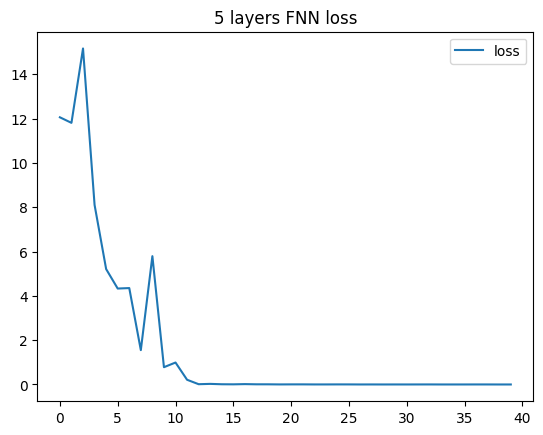

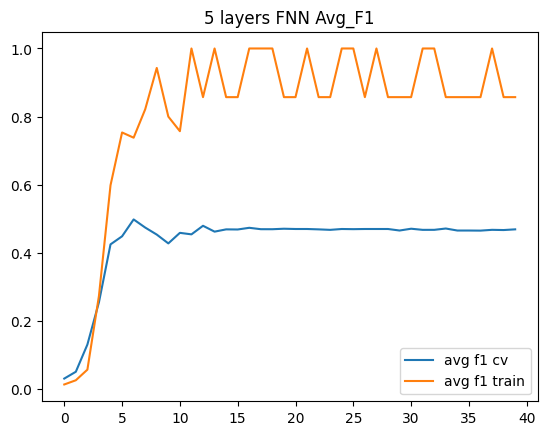

In [75]:
f1_train_list_cpu = [[torch.Tensor.cpu(item) for item in _list] for _list in f1_train_list_list]

loss_list_np = np.array(loss_list_list)
f1_list_np = np.array(f1_list_list)
f1_train_list_np = np.array(f1_train_list_cpu)
print(loss)
loss_list_avg = np.average(loss_list_np,axis = 0)
f1_list_avg = np.average(f1_list_np,axis = 0)
f1_train_list_avg = np.average(f1_train_list_np,axis = 0)
import matplotlib.pyplot as plt
plt.plot(loss_list_avg,label = 'loss')
plt.title("5 layers FNN loss")
plt.legend()
plt.show()
plt.plot(f1_list_avg,label = 'avg f1 cv')
plt.title("5 layers FNN Avg_F1")
plt.plot(f1_train_list_avg,label = 'avg f1 train')
plt.legend()
plt.show()

## 2nd experiment
CNN

In [67]:
def eval_test(model) :
    f1_list = np.array([]) 
    acc_list = np.array([]) 
    for i, data in enumerate(valDataLoader):
        # get the inputs; data is a list of [inputs, labels]
        current_batch_size = len(data)
        inputs =data[:,:,:,:-1]
        
        # defining the targets
        labels,_ = torch.max(data[:,0,:,-1],dim = 1)
        labels = labels.to(torch.int64)
        targets = torch.nn.functional.one_hot(labels,7)

        
        
        inputs = inputs.to(device)
        outputs = model(inputs)
        # forward + backward + optimize
        # zero the parameter gradients
        
        _,Maxs_out_i= torch.max(outputs,dim = 1)
        preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
        ( targets,preds) = (targets.to(device),preds.to(device))
        
        targets = targets.bool()
        preds = preds.bool()

        acc,recall,prec,f1 = eval_fun(preds,targets)
        acc = acc.mean()
        f1 = f1.mean()
        acc_list = np.append(acc_list,acc.cpu().numpy())
        f1_list = np.append(f1_list,f1.cpu().numpy())
    return acc_list.mean(),f1_list.mean()

In [42]:
#split to train / validate

# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

numTrainSamples = int(len(final_data_reshaped) * TRAIN_SPLIT)
numValSamples = int(len(final_data_reshaped) * VAL_SPLIT)
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
(trainData, valData) = torch.utils.data.random_split(final_data_reshaped,[numTrainSamples, numValSamples],generator=torch.Generator().manual_seed(42))

In [45]:

INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 10

#trainData    = torch.utils.data.TensorDataset(torch.tensor(trainData).to(device), torch.tensor(trainData).to(device))
#valData    = torch.utils.data.TensorDataset(torch.tensor(valData).to(device), torch.tensor(valData).to(device))


trainDataLoader = torch.utils.data.DataLoader(trainData, shuffle=True,batch_size=BATCH_SIZE)
valDataLoader = torch.utils.data.DataLoader(valData, batch_size=BATCH_SIZE)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE


In [69]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        kernal = 3
        
        self.conv1 = nn.Conv2d(1, 16, kernal)
        self.conv2 = nn.Conv2d(16, 16, kernal)
        self.pool = nn.MaxPool2d(2)
        self.conv5 = nn.Conv2d(16, 16, 2)
        self.conv6 = nn.Conv2d(16, 8, 2)
        
        self.fc1 = nn.Linear(16800, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 150)
        self.fc4 = nn.Linear(150, 40)
        self.fc5 = nn.Linear(40, 7)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x =self.pool(x)
        
        x = F.relu(self.conv2(x))
        x =self.pool(x)
        
        x = F.relu(self.conv5(x))     
        
        x = F.relu(self.conv6(x))        
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x



In [70]:

import torch.optim as optim



net = Net()
net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_list = []
f1_list = []
f1_train_list = []
for epoch in range(70):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(trainDataLoader):
        current_batch_size = len(data)
        inputs =data[:,:,:,:-1]

        # defining the targets
        labels,_ = torch.max(data[:,:,:,-1],dim = 2)
        labels = labels.to(torch.int64).squeeze()
        targets = torch.nn.functional.one_hot(labels,7).to(torch.float32)
        (inputs, targets) = (inputs.to(device), targets.to(device))
        # zero the parameter gradients
        
        # forward + backward + optimize#
        

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        
        
        _, Maxs_out_i = torch.max(outputs, dim=1)
        
        # print statistics
        running_loss += loss.item()
        
        preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)


        if i % 100 == 0:    # print every 100 mini-batches
            _,_,_,f1_train = eval_fun(preds,targets)
            f1_train = f1_train.mean()
            acc,f1 = eval_test(net)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss :.3f} f1_train : {f1_train:.5f} f1: {f1:.5f} acc:{acc:.5f} ')
            loss_list.append(running_loss)
            f1_list.append(f1)
            f1_train_list.append(f1_train)
            running_loss = 0.0

print('Finished Training')


[1,     1] loss: 6.704 f1_train : 0.09731 f1: 0.06673 acc:0.75268 
[2,     1] loss: 2.254 f1_train : 0.04898 f1: 0.04771 acc:0.75417 
[3,     1] loss: 2.095 f1_train : 0.08376 f1: 0.11578 acc:0.77887 
[4,     1] loss: 2.372 f1_train : 0.04082 f1: 0.06187 acc:0.75714 
[5,     1] loss: 59.820 f1_train : 0.05861 f1: 0.07062 acc:0.76012 
[6,     1] loss: 76.185 f1_train : 0.17936 f1: 0.09772 acc:0.76756 
[7,     1] loss: 2.282 f1_train : 0.06032 f1: 0.09721 acc:0.76935 
[8,     1] loss: 1.745 f1_train : 0.10034 f1: 0.09082 acc:0.77321 
[9,     1] loss: 1.952 f1_train : 0.09780 f1: 0.04493 acc:0.76012 
[10,     1] loss: 1.803 f1_train : 0.07952 f1: 0.06788 acc:0.76250 
[11,     1] loss: 17.446 f1_train : 0.09051 f1: 0.15363 acc:0.78690 
[12,     1] loss: 2.134 f1_train : 0.08163 f1: 0.11742 acc:0.77768 
[13,     1] loss: 1.785 f1_train : 0.10034 f1: 0.14105 acc:0.79405 
[14,     1] loss: 1.596 f1_train : 0.19707 f1: 0.13406 acc:0.78690 
[15,     1] loss: 1.450 f1_train : 0.32975 f1: 0.19898

In [145]:
loss_list_list = []
f1_list_list= []
f1_train_list_list= []

In [153]:
loss_list_list.append(loss_list)
f1_list_list.append(f1_list)
f1_train_list_list.append(f1_train_list)

tensor(0.4785, device='cuda:0', grad_fn=<DivBackward1>)


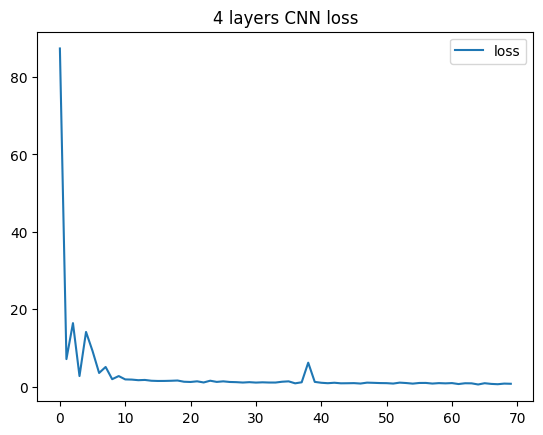

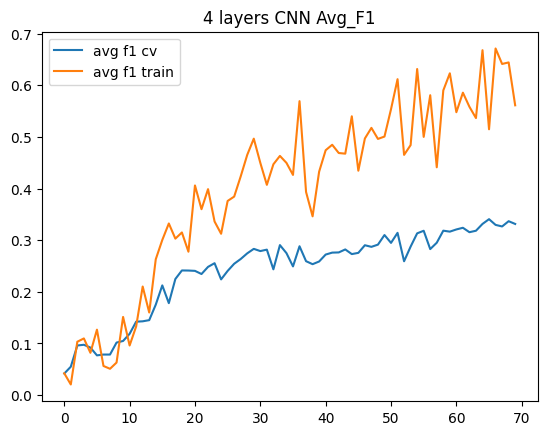

In [154]:
f1_train_list_cpu = [[torch.Tensor.cpu(item) for item in _list] for _list in f1_train_list_list]

loss_list_np = np.array(loss_list_list)
f1_list_np = np.array(f1_list_list)
f1_train_list_np = np.array(f1_train_list_cpu)
print(loss)
loss_list_avg = np.average(loss_list_np,axis = 0)
f1_list_avg = np.average(f1_list_np,axis = 0)
f1_train_list_avg = np.average(f1_train_list_np,axis = 0)
import matplotlib.pyplot as plt
plt.plot(loss_list_avg,label = 'loss')
plt.title("4 layers CNN loss")
plt.legend()
plt.show()
plt.plot(f1_list_avg,label = 'avg f1 cv')
plt.title("4 layers CNN Avg_F1")
plt.plot(f1_train_list_avg,label = 'avg f1 train')
plt.legend()
plt.show()

increasing the complexity of the CNN

In [72]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        kernal = 3
        self.pool = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(1, 16, kernal)
        self.conv2 = nn.Conv2d(16, 16, kernal)
        self.conv3 = nn.Conv2d(16, 16, kernal)
        self.conv4 = nn.Conv2d(16, 16, 3)
        self.conv6 = nn.Conv2d(16, 8, 3)
        
        self.fc1 = nn.Linear(2208, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc4 = nn.Linear(500, 200)
        self.fc5 = nn.Linear(200, 80)
        self.fc7 = nn.Linear(80, 7)
    
    def forward(self, x):
        #x = torch.nn.functional.normalize(x)
        x = F.relu(self.conv1(x))
        x =self.pool(x)
        #x = torch.nn.functional.normalize(x)
        
        x = F.relu(self.conv2(x))
        x =self.pool(x)
        #x = torch.nn.functional.normalize(x)
        
        x = F.relu(self.conv3(x))
        x =self.pool(x)
        
        x = F.relu(self.conv4(x))        
        #x =self.pool(x)
        
        #x = F.relu(self.conv5(x))        
        #x =self.pool(x)
        
        x = F.relu(self.conv6(x))        
        #x =self.pool(x)
        x = torch.nn.functional.normalize(x)
        
        #x = F.relu(self.conv5(x))
        
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = torch.nn.functional.normalize(x)
        #x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        #x = self.fc6(x)
        x = self.fc7(x)
        return x



In [73]:
def eval_test(model) :
    f1_list = np.array([]) 
    acc_list = np.array([]) 
    for i, data in enumerate(valDataLoader):
        # get the inputs; data is a list of [inputs, labels]
        current_batch_size = len(data)
        inputs =data[:,:,:,:-1]
        
        # defining the targets
        labels,_ = torch.max(data[:,0,:,-1],dim = 1)
        labels = labels.to(torch.int64)
        targets = torch.nn.functional.one_hot(labels,7)

        
        
        inputs = inputs.to(device)
        outputs = model(inputs)
        # forward + backward + optimize
        # zero the parameter gradients
        
        _,Maxs_out_i= torch.max(outputs,dim = 1)
        preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
        ( targets,preds) = (targets.to(device),preds.to(device))
        
        targets = targets.bool()
        preds = preds.bool()

        acc,recall,prec,f1 = eval_fun(preds,targets)
        acc = acc.mean()
        f1 = f1.mean()
        acc_list = np.append(acc_list,acc.cpu().numpy())
        f1_list = np.append(f1_list,f1.cpu().numpy())
    return acc_list.mean(),f1_list.mean()

In [75]:
import torch.optim as optim



net = Net()
net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_list = []
f1_list = []
f1_train_list = []
for epoch in range(70):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(trainDataLoader):
        current_batch_size = len(data)
        # get the inputs; data is a list of [inputs, labels]
        inputs =data[:,:,:,:-1]
        
        # defining the targets
        labels,_ = torch.max(data[:,:,:,-1],dim = 2)
        labels = labels.to(torch.int64).squeeze()
        targets = torch.nn.functional.one_hot(labels,7).to(torch.float32)
        (inputs, targets) = (inputs.to(device), targets.to(device))
       
        
        # forward + backward + optimize#
        

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        
        
        _, Maxs_out_i = torch.max(outputs, dim=1)
        
        # print statistics
        running_loss += loss.item()
        
        preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)


        if i % 50 == 0:    # print every 5 mini-batches
            _,_,_,f1_train = eval_fun(preds,targets)
            f1_train = f1_train.mean()
            acc,f1 = eval_test(net)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss :.3f} f1_train : {f1_train:.5f} f1: {f1:.5f} acc:{acc:.5f} ')
            loss_list.append(running_loss)
            f1_list.append(f1)
            f1_train_list.append(f1_train)
            running_loss = 0.0

print('Finished Training')


[1,     1] loss: 1.950 f1_train : 0.01681 f1: 0.03457 acc:0.75506 
[2,     1] loss: 1.937 f1_train : 0.01681 f1: 0.03287 acc:0.75268 
[3,     1] loss: 1.849 f1_train : 0.08887 f1: 0.04072 acc:0.76250 
[4,     1] loss: 1.957 f1_train : 0.01970 f1: 0.11259 acc:0.78155 
[5,     1] loss: 1.659 f1_train : 0.17576 f1: 0.20499 acc:0.80446 
[6,     1] loss: 1.529 f1_train : 0.31667 f1: 0.26933 acc:0.81935 
[7,     1] loss: 1.513 f1_train : 0.22344 f1: 0.17422 acc:0.78690 
[8,     1] loss: 1.474 f1_train : 0.31627 f1: 0.22254 acc:0.80982 
[9,     1] loss: 1.324 f1_train : 0.37344 f1: 0.32956 acc:0.83720 
[10,     1] loss: 0.703 f1_train : 0.45083 f1: 0.31480 acc:0.83839 
[11,     1] loss: 0.993 f1_train : 0.43761 f1: 0.40088 acc:0.86131 
[12,     1] loss: 0.810 f1_train : 0.66592 f1: 0.41481 acc:0.85476 
[13,     1] loss: 1.617 f1_train : 0.33304 f1: 0.36074 acc:0.84643 
[14,     1] loss: 1.088 f1_train : 0.51190 f1: 0.36649 acc:0.85476 
[15,     1] loss: 1.401 f1_train : 0.43927 f1: 0.39573 ac

In [184]:
loss_list_list = []
f1_list_list= []
f1_train_list_list= []

In [189]:
loss_list_list.append(loss_list)
f1_list_list.append(f1_list)
f1_train_list_list.append(f1_train_list)

tensor(0.0072, device='cuda:0', grad_fn=<DivBackward1>)
(3, 70)


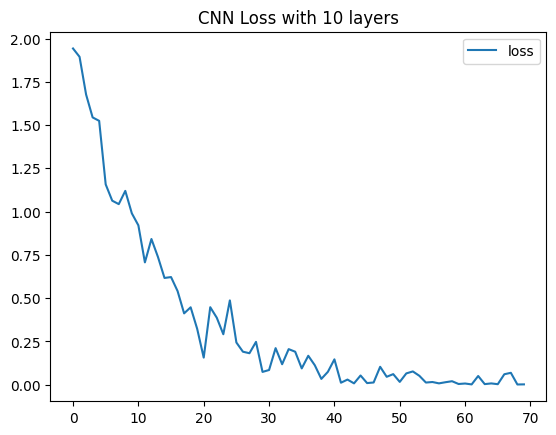

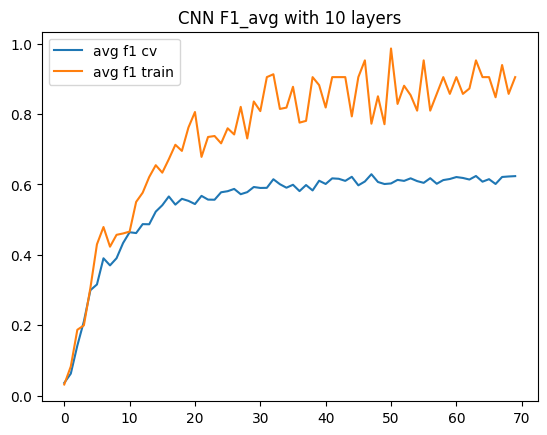

In [194]:

f1_train_list_cpu = [[torch.Tensor.cpu(item) for item in _list] for _list in f1_train_list_list]

loss_list_np = np.array(loss_list_list)
f1_list_np = np.array(f1_list_list)
f1_train_list_np = np.array(f1_train_list_cpu)
print(loss)
loss_list_avg = np.average(loss_list_np,axis = 0)
f1_list_avg = np.average(f1_list_np,axis = 0)
f1_train_list_avg = np.average(f1_train_list_np,axis = 0)
print(loss_list_np.shape)
import matplotlib.pyplot as plt
plt.plot(loss_list_avg,label = 'loss')
plt.title("CNN Loss with 10 layers")
plt.legend()
plt.show()
plt.plot(f1_list_avg,label = 'avg f1 cv')
plt.plot(f1_train_list_avg,label = 'avg f1 train')
plt.legend()
plt.title("CNN F1_avg with 10 layers")
plt.show()

In [203]:
net = Net()
net.cuda()
print("CNN2D param count: " , count_parameters(net) )

CNN2D param count:  2834627


In [14]:
torch.cuda.memory_allocated() /torch.cuda.max_memory_allocated() 

0.6706121791652475

In [130]:
torch.cuda.empty_cache()

In [192]:
print("CNN2D param count: " , count_parameters(net) )

CNN2D param count:  2834627


## 3d expriment 
### MNN


In [104]:
def prepare_data_for_training(the_data,seq_ele = None):
    current_batch_size = len(the_data)
    #the data expected shape [batch,1,seq,features]
    inputs =the_data[:,:,:,:-1]
            
    #mel data inputs
    mel_data = torch.zeros([current_batch_size,3,100,60])
    mel_data[:,0,:,:] = inputs[:,0,:,15:75]
    mel_data[:,1,:,:] = inputs[:,0,:,151:211]
    mel_data[:,2,:,:] = inputs[:,0,:,211:271]
    
    #mfcc data inputs
    mfcc_data = torch.zeros([current_batch_size,9,100,20])
    mfcc_data[:,0,:,:] = inputs[:,0,:,75:95]
    mfcc_data[:,1,:,:] = inputs[:,0,:,95:115]
    mfcc_data[:,2,:,:] = inputs[:,0,:,115:135]
    mfcc_data[:,3,:,:] = inputs[:,0,:,271:291]
    mfcc_data[:,4,:,:] = inputs[:,0,:,291:311]
    mfcc_data[:,5,:,:] = inputs[:,0,:,311:331]
    mfcc_data[:,6,:,:] = inputs[:,0,:,331:351]
    mfcc_data[:,7,:,:] = inputs[:,0,:,351:371]
    mfcc_data[:,8,:,:] = inputs[:,0,:,371:391]
    # other features inputs
    feature_input = torch.zeros([current_batch_size,100,55])
    feature_input[:,:,:15] = inputs[:,0,:,:15]
    feature_input[:,:,15:31] = inputs[:,0,:,135:151]
    feature_input[:,:,31:] = inputs[:,0,:,391:]
    # one feature vector 
    vector_input = torch.zeros([current_batch_size,415])
    if seq_ele is not None :
        vector_input[:,:] = inputs[:,0,seq_ele,:]
    # the labels 
    if seq_ele is None :
        labels,_ = torch.max(the_data[:,0,:,-1],dim = 1)
    else:
        labels = the_data[:,0,seq_ele,-1]
    
    labels = labels.to(torch.int64)
    targets = torch.nn.functional.one_hot(labels,7).to(torch.float32)
    (mel_data,mfcc_data,feature_input, vector_input,targets) = (mel_data.to(device),mfcc_data.to(device),feature_input.to(device),vector_input.to(device), targets.to(device))
    return mel_data,mfcc_data,feature_input,vector_input,targets

In [103]:
def eval_test(model) :
    f1_list = np.array([]) 
    acc_list = np.array([]) 
    for i, data in enumerate(valDataLoader):
        
            # data preparation
            current_batch_size = len(data)
            mel_data,mfcc_data,feature_input,vector_input,targets = prepare_data_for_training(data)
           
            outputs = model(mel_data,mfcc_data,feature_input)
            
            _,Maxs_out_i= torch.max(outputs,dim = 1)
            preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
            preds = preds.to(device)
            
            targets = targets.bool()
            preds = preds.bool()
            acc,recall,prec,f1 = eval_fun(preds,targets)

            acc = acc.mean()
            f1 = f1.mean()
            acc_list = np.append(acc_list,acc.cpu().numpy())
            f1_list = np.append(f1_list,f1.cpu().numpy())
    return acc_list.mean(),f1_list.mean()

In [106]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 22, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(22, 22, 3),
            nn.BatchNorm2d(22),
            nn.ReLU(),
            nn.Conv2d(22, 22, 3),
            nn.BatchNorm2d(22),
            nn.ReLU(),
            nn.Conv2d(22, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, 3)
        )        
        self.cnn2 = nn.Sequential(
            nn.Conv2d(9, 30, 3),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            #nn.MaxPool2d(2),
            nn.Conv2d(30, 30, 3),
            nn.ReLU(),
            nn.Conv2d(30, 30, 3),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Conv2d(30, 30, 3),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Conv2d(30, 30, 3),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Conv2d(30, 15, 3),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(15, 6, 3)
        )
        self.cnn1d = nn.Sequential(
            nn.Conv1d(55, 55, 3),
            nn.BatchNorm1d(55),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(55, 55, 3),
            nn.ReLU(),
            #nn.MaxPool1d(2),
            nn.Conv1d(55, 55, 3),
            nn.ReLU(),
            #nn.MaxPool1d(2),
            nn.Conv1d(55, 25, 3),
            nn.BatchNorm1d(25),
            nn.ReLU(),
            nn.Conv1d(25, 25, 3),
            nn.BatchNorm1d(25),
            nn.ReLU(),
            #nn.MaxPool1d(2),
            nn.Conv1d(25, 8, 3)
        )
        self.fnn = nn.Sequential(
            nn.ReLU(),
            nn.Linear(864, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Linear(25, 7)
        )

    def forward(self,mel_data,mfcc_data,feature_input):
        mel_data = torch.nn.functional.normalize(mel_data)
        mfcc_data = torch.nn.functional.normalize(mfcc_data)
        feature_input = torch.nn.functional.normalize(feature_input)
        
        x1 = self.cnn1(mel_data)
        x1 = torch.flatten(x1, 1)
        
        x2 = self.cnn2(mfcc_data)
        x2 = torch.flatten(x2, 1)
        
        x3 = torch.transpose(feature_input,1,2)
        x3 = self.cnn1d(x3)
        x3 = torch.flatten(x3, 1)
        #x = x2
        x = torch.cat((x1,x2,x3),-1)
        x = torch.nn.functional.normalize(x)
        x = self.fnn(x)
        return x



In [110]:
import torch.optim as optim


net = Net()
net.cuda()

wights = torch.from_numpy(wight).to(device)
criterion = nn.CrossEntropyLoss(weight=wights)
optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_list = []
acc_list = []
f1_list = []
f1_train_list = []
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainDataLoader):

        # data preparation
        current_batch_size = len(data)
        mel_data,mfcc_data,feature_input,vector_input,targets = prepare_data_for_training(data)


        # forward + backward + optimize#
        

        optimizer.zero_grad()
        outputs = net(mel_data,mfcc_data,feature_input)
        loss = criterion(outputs, targets)
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        
        
        _, Maxs_out_i = torch.max(outputs, dim=1)
        preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
        preds = preds.to(device)
        # print statistics
        running_loss += loss.item()
        


        if i % 50 == 0:    # print every 50 mini-batches
            _,_,_,f1_train = eval_fun(preds,targets)
            f1_train = f1_train.mean()
            acc,f1 = eval_test(net)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss :.3f} f1_train : {f1_train:.5f} f1: {f1:.5f} acc:{acc}')
            loss_list.append(running_loss)
            f1_list.append(f1)
            f1_train_list.append(f1_train)
            acc_list.append(acc)
            running_loss = 0.0

print('Finished Training')


[1,     1] loss: 16.416 f1_train : 0.03827 f1: 0.06924 acc:0.7580357372760773
[2,     1] loss: 8.117 f1_train : 0.36954 f1: 0.26267 acc:0.8345238447189331
[3,     1] loss: 6.411 f1_train : 0.49063 f1: 0.38893 acc:0.8586309909820556
[4,     1] loss: 9.992 f1_train : 0.64422 f1: 0.50611 acc:0.8845238447189331
[5,     1] loss: 4.135 f1_train : 0.78912 f1: 0.49562 acc:0.8830357551574707
[6,     1] loss: 9.333 f1_train : 0.68716 f1: 0.51598 acc:0.8821428894996644
[7,     1] loss: 2.663 f1_train : 0.71082 f1: 0.53047 acc:0.8931547999382019
[8,     1] loss: 2.445 f1_train : 0.67912 f1: 0.61061 acc:0.9214286088943482
[9,     1] loss: 1.116 f1_train : 0.75974 f1: 0.58882 acc:0.9160714626312256
[10,     1] loss: 0.854 f1_train : 0.94398 f1: 0.55125 acc:0.8892857372760773
[11,     1] loss: 1.318 f1_train : 0.93571 f1: 0.54272 acc:0.90476194024086
[12,     1] loss: 0.586 f1_train : 0.84874 f1: 0.58266 acc:0.911904799938202
[13,     1] loss: 1.237 f1_train : 0.94033 f1: 0.58960 acc:0.90714287757873


(dot.exe:28876): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


RNN param count:  957886


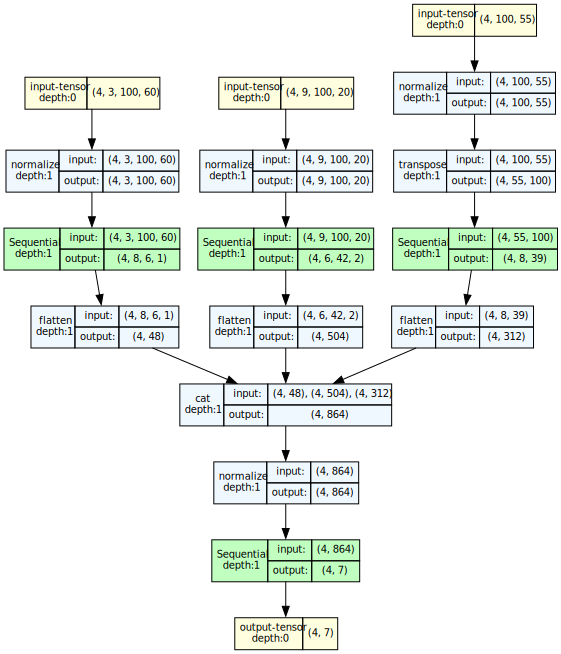

In [ ]:
from torchview import draw_graph

net = Net()
print("RNN param count: " , count_parameters(net) )
#print(net)


# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(net, input_size=((current_batch_size,3,100,60),(current_batch_size,9,100,20),(current_batch_size,100,55)),depth=1, expand_nested=True)
model_graph.visual_graph

In [80]:
loss_list_list = []
f1_list_list= []
f1_train_list_list= []

In [81]:
loss_list_list.append(loss_list)
f1_list_list.append(f1_list)
f1_train_list_list.append(f1_train_list)

In [82]:
loss_list_list_2 = []
f1_list_list_2= []
f1_train_list_list_2= []

In [83]:
loss_list_list_2.append(loss_list)
f1_list_list_2.append(f1_list)
f1_train_list_list_2.append(f1_train_list)

f1_train_list_cpu_2 = [[torch.Tensor.cpu(item) for item in _list] for _list in f1_train_list_list_2]

loss_list_np_2 = np.array(loss_list_list_2)
f1_list_np_2 = np.array(f1_list_list_2)
f1_train_list_np_2 = np.array(f1_train_list_cpu_2)

loss_list_avg_2 = np.average(loss_list_np_2,axis = 0)
f1_list_avg_2 = np.average(f1_list_np_2,axis = 0)
f1_train_list_avg_2 = np.average(f1_train_list_np_2,axis = 0)

In [84]:
loss_list_list_3 = []
f1_list_list_3= []
f1_train_list_list_3= []

In [85]:
loss_list_list_3.append(loss_list)
f1_list_list_3.append(f1_list)
f1_train_list_list_3.append(f1_train_list)

f1_train_list_cpu_3 = [[torch.Tensor.cpu(item) for item in _list] for _list in f1_train_list_list_3]

loss_list_np_3 = np.array(loss_list_list_3)
f1_list_np_3 = np.array(f1_list_list_3)
f1_train_list_np_3 = np.array(f1_train_list_cpu_3)

loss_list_avg_3 = np.average(loss_list_np_3,axis = 0)
f1_list_avg_3 = np.average(f1_list_np_3,axis = 0)
f1_train_list_avg_3 = np.average(f1_train_list_np_3,axis = 0)

tensor(0.0203, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)
(1, 120)


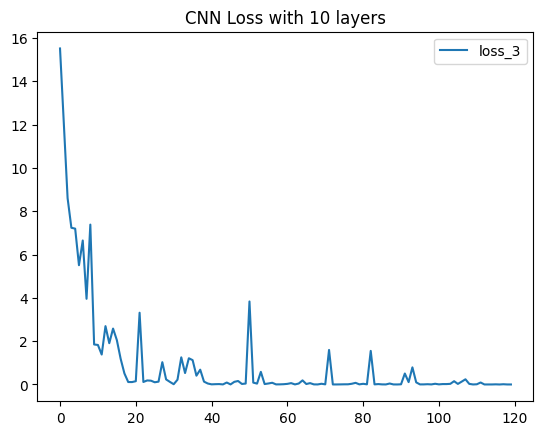

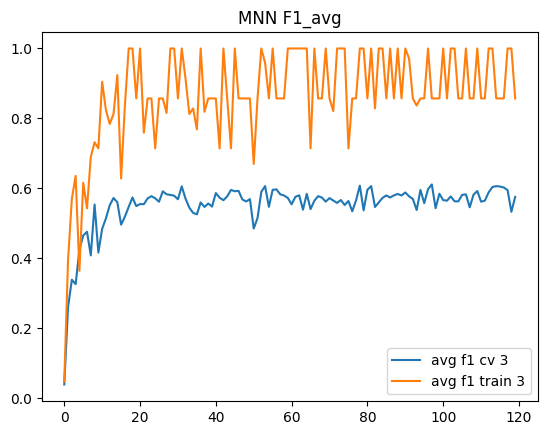

In [86]:

f1_train_list_cpu = [[torch.Tensor.cpu(item) for item in _list] for _list in f1_train_list_list]

loss_list_np = np.array(loss_list_list)
f1_list_np = np.array(f1_list_list)
f1_train_list_np = np.array(f1_train_list_cpu)
print(loss)
loss_list_avg = np.average(loss_list_np,axis = 0)
f1_list_avg = np.average(f1_list_np,axis = 0)
f1_train_list_avg = np.average(f1_train_list_np,axis = 0)
print(loss_list_np.shape)
import matplotlib.pyplot as plt
#plt.plot(loss_list_avg,label = 'loss')
#plt.plot(loss_list_avg_2,label = 'loss_2')
plt.plot(loss_list_avg_3,label = 'loss_3')
plt.title("CNN Loss with 10 layers")
plt.legend()
plt.show()
#plt.plot(f1_list_avg,label = 'avg f1 cv')
#plt.plot(f1_list_avg_2,label = 'avg f1 cv 2')
plt.plot(f1_list_avg_3,label = 'avg f1 cv 3')
#plt.plot(f1_train_list_avg,label = 'avg f1 train')
#plt.plot(f1_train_list_avg_2,label = 'avg f1 train 2')
plt.plot(f1_train_list_avg_3,label = 'avg f1 train 3')
plt.legend()
plt.title("MNN F1_avg")
plt.show()

CNN 1D

In [114]:
class Net(torch.nn.Module):
    """#
    Dense feed-forward network tailored to process latch sequence data.
    """
    
    def __init__(self ):
        super().__init__()
        num_instance = 100
        num_features = 415
        num_hidden_layers = 500
        hidden_channels = 3
        kernel_size = 3
        input_channels = 415
        num_classes = 7
        use_batchnormalization = False
        activation_function = nn.ReLU()
        hidden_list = []
        for _ in range(0):
            layer = nn.Conv1d(in_channels=input_channels, out_channels=hidden_channels, kernel_size=kernel_size,padding=kernel_size//2)
            hidden_list.append(layer)
            if use_batchnormalization :
                hidden_list.append(nn.BatchNorm1d(hidden_channels))
            hidden_list.append(activation_function)
            input_channels = hidden_channels
            
         # cnn layer   
        cnn1 = nn.Conv1d(in_channels=input_channels, out_channels=700, kernel_size=kernel_size,padding=kernel_size//2)
        cnn2 = nn.Conv1d(in_channels=700, out_channels=400, kernel_size=kernel_size,padding=kernel_size//2)
        cnn3 = nn.Conv1d(in_channels=400, out_channels=300, kernel_size=kernel_size,padding=kernel_size//2)
        cnn4 = nn.Conv1d(in_channels=300, out_channels=200, kernel_size=kernel_size,padding=kernel_size//2)
        cnn5 = nn.Conv1d(in_channels=200, out_channels=100, kernel_size=kernel_size,padding=kernel_size//2)
        cnn6 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=kernel_size,padding=kernel_size//2)
        cnn7 = nn.Conv1d(in_channels=100, out_channels=50, kernel_size=kernel_size,padding=kernel_size//2)
        
        
        # fnn layers
        flat = nn.Flatten()
        fc1 = nn.Linear(50*(100//(2*2*2)),300)
        fc2 = nn.Linear(300,150)
        fc3 = nn.Linear(150, 84)
        fc4 = nn.Linear(84, 40)
        fc5 = nn.Linear(40, 7)
        
        # append cnn 
        hidden_list.append(cnn1)
        hidden_list.append(nn.BatchNorm1d(700))
        hidden_list.append(activation_function)
        hidden_list.append(nn.MaxPool1d(2))
        
        hidden_list.append(cnn2)
        #hidden_list.append(nn.BatchNorm1d(400))
        hidden_list.append(activation_function)
        #hidden_list.append(nn.MaxPool1d(2))
        
        hidden_list.append(cnn3)
        hidden_list.append(nn.BatchNorm1d(300))
        hidden_list.append(activation_function)
        hidden_list.append(nn.MaxPool1d(2))
        
        hidden_list.append(cnn4)
        #hidden_list.append(nn.BatchNorm1d(200))
        hidden_list.append(activation_function)
        
        hidden_list.append(cnn5)
        hidden_list.append(nn.BatchNorm1d(100))
        hidden_list.append(activation_function)
        hidden_list.append(nn.MaxPool1d(2))
        
        hidden_list.append(cnn6)
        #hidden_list.append(nn.BatchNorm1d(50))
        hidden_list.append(activation_function)
        #hidden_list.append(nn.MaxPool1d(2))
        
        hidden_list.append(cnn7)
        hidden_list.append(nn.BatchNorm1d(50))
        hidden_list.append(activation_function)
        
        #append flatten
        
        hidden_list.append(flat)
        hidden_list.append(fc1)
        hidden_list.append(activation_function)
        hidden_list.append(fc2)
        hidden_list.append(activation_function)
        hidden_list.append(fc3)
        hidden_list.append(activation_function)
        hidden_list.append(fc4)
        hidden_list.append(activation_function)
        hidden_list.append(fc5)

        
        self.layers = nn.Sequential(*hidden_list)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.transpose(x,1,2)
        x = self.layers(x)
        return x
    


In [115]:
def eval_test(model) :
    f1_list = np.array([]) 
    for i, data in enumerate(valDataLoader):
        
            current_batch_size = len(data)
            inputs =data[:,0,:,:-1]
            
            # defining the targets
            labels,_ = torch.max(data[:,0,:,-1],dim = 1)
            labels = labels.to(torch.int64)
            targets = torch.nn.functional.one_hot(labels,7).to(torch.float32) 

            (inputs, targets) = (inputs.to(device), targets.to(device))
           
            optimizer.zero_grad()
            outputs = model(inputs)
            
            _,Maxs_out_i= torch.max(outputs,dim = 1)        
            preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
            preds = preds.to(device)

            targets = targets.bool()
            preds = preds.bool()
            acc,recall,prec,f1 = eval_fun(preds,targets)

            f1 = f1.mean()
            f1_list = np.append(f1_list,f1.cpu().numpy())
            del(outputs)
    return f1_list.mean()

In [116]:
import torch.optim as optim


net = Net()
net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_list = []
acc_list = []
f1_list = []
f1_train_list = []
for epoch in range(70):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainDataLoader):
        current_batch_size = len(data)
        # get the inputs; data is a list of [inputs, labels]
        inputs =data[:,0,:,:-1]
        
        # defining the targets
        labels,_ = torch.max(data[:,0,:,-1],dim = 1)
        labels = labels.to(torch.int64)
        targets = torch.nn.functional.one_hot(labels,7).to(torch.float32) 
        (inputs, targets) = (inputs.to(device), targets.to(device))



        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()    
        optimizer.step()
        
        
        _, Maxs_out_i = torch.max(outputs, dim=1)   
        preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
        preds = preds.to(device)
 
        
        # print statistics
        running_loss += loss.item()     
        if i % 50 == 0:    # print every 5 mini-batches
            _,_,_,f1_train = eval_fun(preds,targets)
            f1_train = f1_train.mean()
            f1 = eval_test(net)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss :.3f} f1_train : {f1_train:.5f} f1: {f1:.5f} ')
            loss_list.append(running_loss)
            f1_list.append(f1)
            f1_train_list.append(f1_train)
            #print (f'outputs{nn.Softmax( outputs)}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 1.981 f1_train : 0.01681 f1: 0.06931 
[2,     1] loss: 1.959 f1_train : 0.02449 f1: 0.04466 
[3,     1] loss: 1.819 f1_train : 0.04511 f1: 0.05642 
[4,     1] loss: 1.867 f1_train : 0.09395 f1: 0.08263 
[5,     1] loss: 1.842 f1_train : 0.05861 f1: 0.08850 
[6,     1] loss: 1.751 f1_train : 0.12254 f1: 0.09897 
[7,     1] loss: 1.723 f1_train : 0.10176 f1: 0.12584 
[8,     1] loss: 1.869 f1_train : 0.08964 f1: 0.11487 
[9,     1] loss: 1.753 f1_train : 0.05405 f1: 0.11631 
[10,     1] loss: 1.754 f1_train : 0.13500 f1: 0.14428 
[11,     1] loss: 1.664 f1_train : 0.19048 f1: 0.12323 
[12,     1] loss: 1.674 f1_train : 0.18013 f1: 0.12231 
[13,     1] loss: 1.735 f1_train : 0.09951 f1: 0.09745 
[14,     1] loss: 1.906 f1_train : 0.04762 f1: 0.13028 
[15,     1] loss: 1.615 f1_train : 0.14748 f1: 0.15116 
[16,     1] loss: 1.718 f1_train : 0.20078 f1: 0.15355 
[17,     1] loss: 1.655 f1_train : 0.13054 f1: 0.18252 
[18,     1] loss: 1.879 f1_train : 0.20014 f1: 0.18079 
[

In [225]:
loss_list_list = []
f1_list_list= []
f1_train_list_list= []

In [235]:
loss_list_list.append(loss_list)
f1_list_list.append(f1_list)
f1_train_list_list.append(f1_train_list)

(4, 70)
(4, 70)


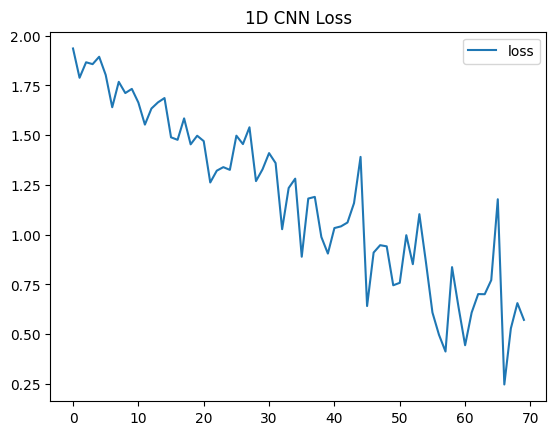

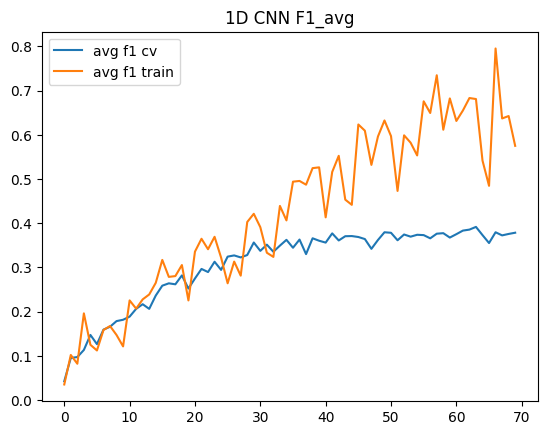

In [237]:

f1_train_list_cpu = [[torch.Tensor.cpu(item) for item in _list] for _list in f1_train_list_list]

loss_list_np = np.array(loss_list_list)
f1_list_np = np.array(f1_list_list)
f1_train_list_np = np.array(f1_train_list_cpu)
print(loss_list_np.shape)
loss_list_avg = np.average(loss_list_np,axis = 0)
f1_list_avg = np.average(f1_list_np,axis = 0)
f1_train_list_avg = np.average(f1_train_list_np,axis = 0)
print(loss_list_np.shape)
import matplotlib.pyplot as plt
plt.plot(loss_list_avg,label = 'loss')
plt.title("1D CNN Loss")
plt.legend()
plt.show()
plt.plot(f1_list_avg,label = 'avg f1 cv')
plt.plot(f1_train_list_avg,label = 'avg f1 train')
plt.legend()
plt.title("1D CNN F1_avg")
plt.show()

RNN

RNN param count:  120039007
Net(
  (rnn1): RNN(415, 1000, num_layers=60, batch_first=True)
  (fc1): Linear(in_features=1000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=7, bias=True)
  (relu_1): ReLU()
)



(dot.exe:29396): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


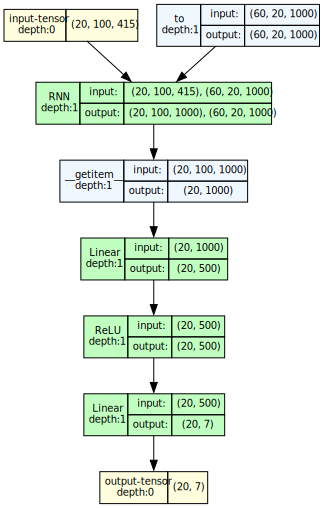

In [47]:
from torchview import draw_graph
print("RNN param count: " , count_parameters(net) )
print(net)


# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(net, input_size=(BATCH_SIZE, 100,415))
model_graph.visual_graph

In [117]:

#split to train / validate

# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
print(final_data_reshaped.shape)
numTrainSamples = int(len(final_data_reshaped) * TRAIN_SPLIT)
numValSamples = int(len(final_data_reshaped) * VAL_SPLIT)
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
(trainData, valData) = torch.utils.data.random_split(final_data_reshaped,[numTrainSamples, numValSamples],generator=torch.Generator().manual_seed(42))

INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 10

#trainData    = torch.utils.data.TensorDataset(torch.tensor(trainData).to(device), torch.tensor(trainData).to(device))
#valData    = torch.utils.data.TensorDataset(torch.tensor(valData).to(device), torch.tensor(valData).to(device))


trainDataLoader = torch.utils.data.DataLoader(trainData, shuffle=True,batch_size=BATCH_SIZE)
valDataLoader = torch.utils.data.DataLoader(valData, batch_size=BATCH_SIZE)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE


(1200, 1, 100, 416)


In [118]:
class Net(torch.nn.Module):
    """#
    Dense feed-forward network tailored to process latch sequence data.
    """
    
    def __init__(self ):
        super().__init__()
        kernel = 5
        num_instance = 100
        self.num_features = 415
        self.hidden_size = 600
        self.num_layers = 3
        self.lstm = nn.LSTM(input_size=self.num_features, hidden_size=self.hidden_size, num_layers = self.num_layers, batch_first=True)
        self.fc1 = nn.Linear(self.lstm.hidden_size, 500)
        self.fc2 = nn.Linear(500, 300)
        self.fc3 = nn.Linear(300, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, 7)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        x, _ = self.lstm(x, (h0, c0))  # shape = (batch_size, seq_length, hidden_size)
        x = torch.relu(self.fc1(x[:, -1, :]))
        #x = self.rnn1(x)[1][0].squeeze()
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return self.fc5(x)

In [122]:
def eval_test(model) :
    f1_list = np.array([]) 
    for i, data in enumerate(valDataLoader):
            # get the inputs; data is a list of [inputs, labels]
            current_batch_size = len(data)
            inputs =data[:,0,:,:-1]
            
            # defining the targets
            labels,_ = torch.max(data[:,0,:,-1],dim = 1)
            
            labels = labels.to(torch.int64)
            targets = torch.nn.functional.one_hot(labels,7).to(torch.float32) 
            (inputs, targets) = (inputs.to(device), targets.to(device))
            

            # forward + backward + optimize
            optimizer.zero_grad()
            outputs = model(inputs)

            _,Maxs_out_i= torch.max(outputs,dim = 1)       
            preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
            preds = preds.to(device)

            targets = targets.bool()
            preds = preds.bool()

            acc,recall,prec,f1 = eval_fun(preds,targets)
            f1 = f1.mean()
            f1_list = np.append(f1_list,f1.cpu().numpy())

    return acc.mean(),f1_list.mean()

In [123]:
import torch.optim as optim


#net = Net()
#net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_list = []
acc_list = []
f1_list = []
f1_train_list = []
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainDataLoader):
        current_batch_size = len(data)
        # get the inputs; data is a list of [inputs, labels]
        inputs =data[:,0,:,:-1]

        # defining the targets
        labels,_ = torch.max(data[:,0,:,-1],dim = 1)
        labels = labels.to(torch.int64)
        targets = torch.nn.functional.one_hot(labels,7).to(torch.float32) 
        (inputs, targets) = (inputs.to(device), targets.to(device))
  
        # forward + backward + optimize#
        

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()    
        optimizer.step()
        
        
       
        
        # print statistics
        running_loss += loss.item()
        


 
        if i % 50 == 0:    # print every 5 mini-batches
            _, Maxs_out_i = torch.max(outputs, dim=1)       
            preds = torch.nn.functional.one_hot(Maxs_out_i.to(torch.int64),7)
            preds = preds.to(device)

            _,_,_,f1_train = eval_fun(preds,targets)
            f1_train = f1_train.mean()
            acc,f1 = eval_test(net)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss :.3f} f1_train : {f1_train:.5f} f1: {f1:.5f} acc: {acc:.5f} ')
            loss_list.append(running_loss)
            f1_list.append(f1)
            f1_train_list.append(f1_train)
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 1.262 f1_train : 0.48168 f1: 0.32243 acc: 0.85714 
[2,     1] loss: 0.510 f1_train : 0.70357 f1: 0.35084 acc: 0.83333 
[3,     1] loss: 0.710 f1_train : 0.79586 f1: 0.35026 acc: 0.83333 
[4,     1] loss: 0.592 f1_train : 0.65748 f1: 0.33462 acc: 0.85714 
[5,     1] loss: 0.572 f1_train : 0.70132 f1: 0.34659 acc: 0.88095 
[6,     1] loss: 0.406 f1_train : 0.90340 f1: 0.36174 acc: 0.90476 
[7,     1] loss: 0.534 f1_train : 0.87500 f1: 0.35415 acc: 0.88095 
[8,     1] loss: 0.306 f1_train : 0.75698 f1: 0.32868 acc: 0.85714 
[9,     1] loss: 0.831 f1_train : 0.58318 f1: 0.33513 acc: 0.85714 
[10,     1] loss: 0.311 f1_train : 0.74177 f1: 0.37198 acc: 0.90476 
[11,     1] loss: 0.614 f1_train : 0.76327 f1: 0.34933 acc: 0.90476 
[12,     1] loss: 0.591 f1_train : 0.66780 f1: 0.34614 acc: 0.85714 
[13,     1] loss: 0.242 f1_train : 0.92076 f1: 0.34472 acc: 0.88095 
[14,     1] loss: 0.326 f1_train : 0.91360 f1: 0.31462 acc: 0.90476 
[15,     1] loss: 0.515 f1_train : 0.68903 

In [437]:
net.cpu()
del(net)
torch.cuda.empty_cache()